In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import seaborn as sns

In [3]:
X_test = pd.read_csv('Data/X_test.csv')
X_train = pd.read_csv('Data/X_train.csv')
y_train = pd.read_csv('Data/y_train.csv')

In [4]:
def get_values_X_2D(X):
    n_timestep, n_feature = 128, 10
    X_data_ori = X.iloc[:,3:].values # original values
    #X_data = StandardScaler().fit_transform(X_data_ori)# standarlize the data
    #X_data = MinMaxScaler().fit_transform(X_data)# standarlize the data

    X_data_2D = np.reshape(X_data_ori, (int(len(X_data_ori)/n_timestep),n_timestep,n_feature)) # convert to 2D images
    return (X_data_2D)

In [5]:
X_data_2D = get_values_X_2D(X_train)
all_group = y_train.surface.unique()

In [6]:
all_group

array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

## LSTM models

In [13]:
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam

In [21]:
def prepare_dataset(X, y_data):
    n_timestep, n_feature = 128, 10
    
    X_data = X.iloc[:,3:].values # original values
    #X_data = StandardScaler().fit_transform(X_data)# standarlize the data
    #X_data = MinMaxScaler().fit_transform(X_data)# standarlize the data

    X_data_2D = np.reshape(X_data, (int(len(X_data)/n_timestep),n_timestep,n_feature)) # convert to 2D images
    
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_data)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    y_onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    X_train, X_test, y_train, y_test = train_test_split(X_data_2D, y_onehot_encoded, test_size=0.4, random_state=42)
    print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return(label_encoder, X_train, y_train, X_test, y_test)


In [24]:
#fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 10, 500
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    class_weight = {0: 2.,
                1: 1.,
                2: 3.,
                3: 1.,
                4: 1.,
                5: 3.,
                6: 4.,
                7: 20.,
                8: 1}
    
    model = Sequential()
    #model.add(Input(shape = (n_timesteps,n_features)))
    model.add(BatchNormalization(input_shape = (n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(LSTM(100, return_sequences=True))

    model.add(LSTM(100, return_sequences=False))

    #model.add(Flatten())
    model.add(Dense(n_outputs, activation='softmax'))
    model.summary()
    
    
    
    opt = Adam(lr = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    # fit network
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint('best_model_lstm_only.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=epochs, \
                        batch_size=batch_size, verbose=verbose,  class_weight=class_weight, callbacks=[es, mc])

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # load data
    label_encoder, trainX, trainy, testX, testy = prepare_dataset(X_train, y_train.surface)
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

(2286, 128, 10) (1524, 128, 10) (2286, 9) (1524, 9)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 128, 10)           40        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 126, 64)           1984      
_________________________________________________________________
lstm_9 (LSTM)                (None, 126, 100)          66000     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 909       
Total params: 149,333
Trainable params: 149,313
Non-trainable params: 20
_________________________________________________________________
Train on 2286 samples, validate on 1524 samples
Epoch 1/10
2286/2286 [=============

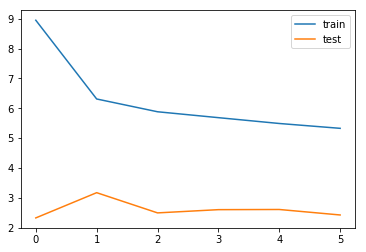

>#1: 22.178
[22.17847726007146]
Accuracy: 22.178% (+/-0.000)


In [25]:
# run the experiment
run_experiment(1)